In [11]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import apply_affine_transform
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight


from PIL import Image
import matplotlib.pyplot as plt

from collections import Counter


# Load Dataset

In [12]:
CSV_FILE_NAME = './data/my_file.csv'
# CSV_FILE_NAME = './data/my_file_400.csv'
arr = pd.read_csv(CSV_FILE_NAME, header=None)

In [13]:
X, y_class, y_reg = arr.iloc[:, :-5].values, arr.iloc[:, -5:-4].values, arr.iloc[:, -4:].values
print(y_reg)
X = X.reshape(-1, 200, 200, 1)
# X = X.reshape(-1, 400, 400, 1)


# one hot encoding
# y_class = tf.keras.utils.to_categorical(y_class, num_classes=17)

# dataset split
# X_train, X_test, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=42, stratify=y_class)
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)


# if no data augmentation
# class_weights = class_weight.compute_class_weight(class_weight='balanced',
#                                                   classes=np.unique(y_train_class.argmax(axis=1)),
#                                                   y=y_train_class.argmax(axis=1))

# class_weights_dict = dict(enumerate(class_weights))


[[0.523969 0.458252 0.474916 0.897087]
 [0.524526 0.378641 0.299889 0.625243]
 [0.569119 0.506796 0.397993 0.88932 ]
 ...
 [0.       0.       0.       0.      ]
 [0.       0.       0.       0.      ]
 [0.       0.       0.       0.      ]]


# Model

In [14]:
model = models.Sequential([
    layers.Input(shape=(200, 200, 1)),
    # layers.Input(shape=(400, 400, 1)),
    layers.Conv2D(32, 3, activation='relu'),
    # layers.Conv2D(32, 3, kernel_regularizer=l2(0.0001), activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu'),
    # layers.Conv2D(64, 3, kernel_regularizer=l2(0.0001), activation='relu'),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(4, activation='sigmoid')
])


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

# f1_metric = tf.metrics.F1Score(average='macro')
# f1_metric = tf.metrics.F1Score(average='weighted') # if no data augmentation
# mse_metric = tf.metrics.Mean


model.compile(optimizer=Adam(0.001),
              loss="mse",
              metrics=['accuracy'])


model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 198, 198, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 147456)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 147456)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     9,437,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,456,324 (36.07 MB)

 Trainable params: 9,456,324 (36.07 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model.fit(X_train, y_train_reg, epochs=50, validation_data=(X_test, y_test_reg))

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 492ms/step - accuracy: 0.4434 - loss: 0.0892 - val_accuracy: 0.7615 - val_loss: 0.0326
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 463ms/step - accuracy: 0.6652 - loss: 0.0297 - val_accuracy: 0.8000 - val_loss: 0.0255
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 460ms/step - accuracy: 0.7486 - loss: 0.0206 - val_accuracy: 0.8077 - val_loss: 0.0234
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 469ms/step - accuracy: 0.8117 - loss: 0.0151 - val_accuracy: 0.7923 - val_loss: 0.0234
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 481ms/step - accuracy: 0.8567 - loss: 0.0117 - val_accuracy: 0.7538 - val_loss: 0.0243
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 491ms/step - accuracy: 0.8470 - loss: 0.0099 - val_accuracy: 0.7692 - val_loss: 0.0211
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 483ms/step - accuracy: 0.8230 - loss: 0.0084 - val_accuracy: 0.7462 - val_loss: 0.0217
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 468ms/step - accuracy: 0.8164 - loss: 0.0065 - val_accuracy: 0

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

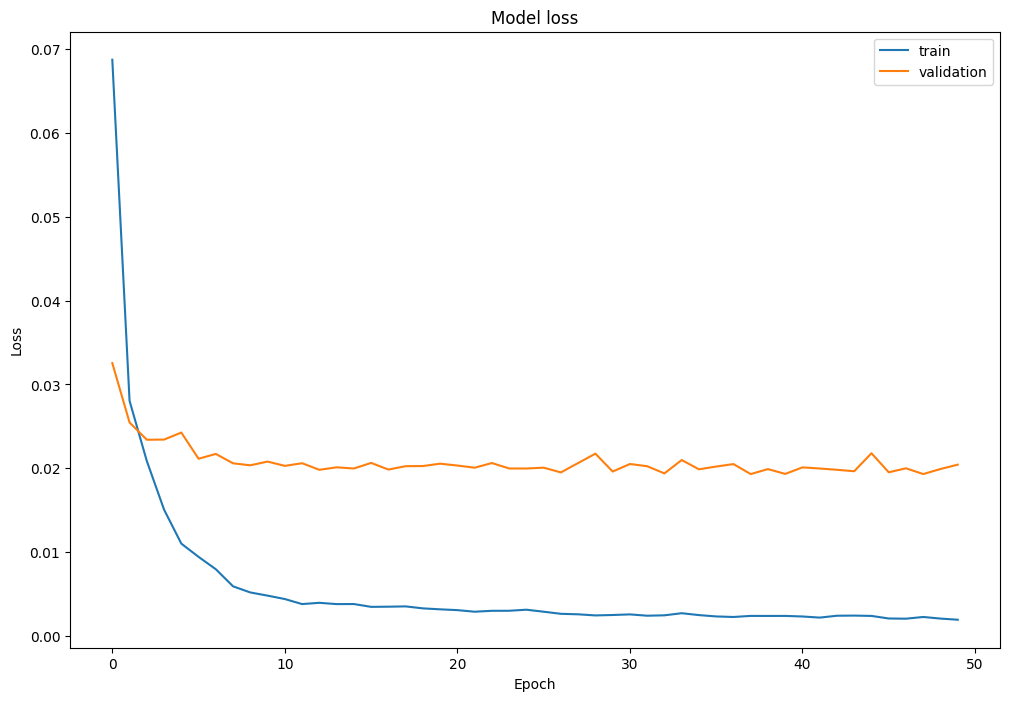

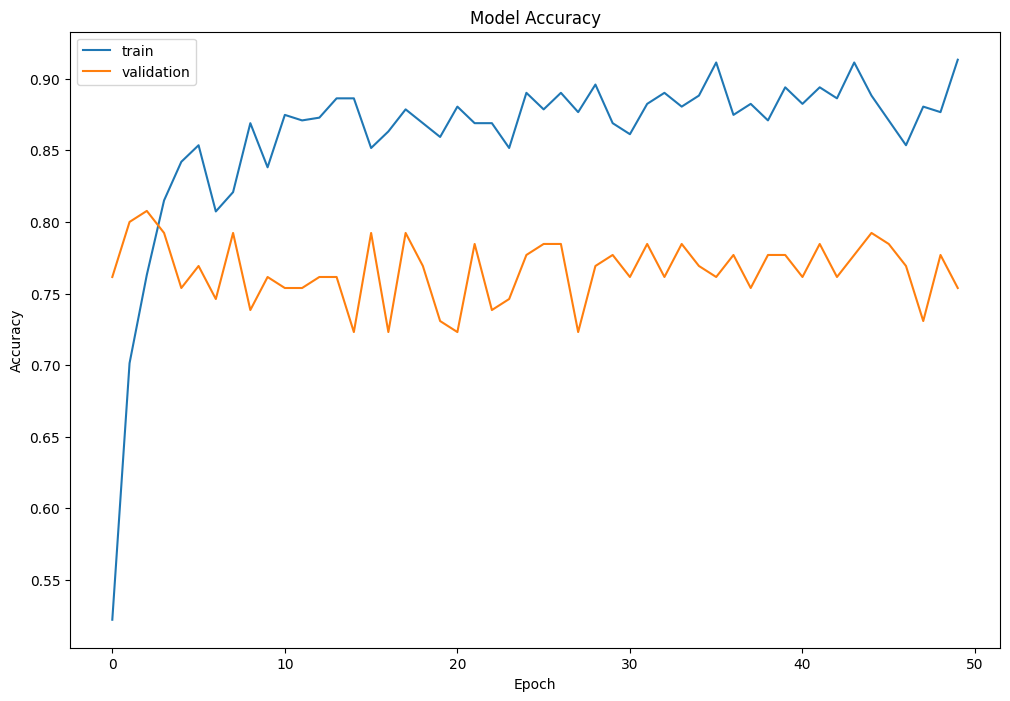

In [16]:
# Convert model history dictionary to DataFrame
df_loss_acc = pd.DataFrame(model.history.history)

# Select loss columns and rename
df_loss = df_loss_acc[['loss', 'val_loss']].copy()
df_loss.rename(columns={'loss': 'train', 'val_loss': 'validation'}, inplace=True)

# Select accuracy columns and rename
df_acc = df_loss_acc[['accuracy', 'val_accuracy']].copy()
df_acc.rename(columns={'accuracy': 'train', 'val_accuracy': 'validation'}, inplace=True)

# Plot model loss
df_loss.plot(title='Model loss', figsize=(12, 8)).set(xlabel='Epoch', ylabel='Loss')

# Plot model accuracy
df_acc.plot(title='Model Accuracy', figsize=(12, 8)).set(xlabel='Epoch', ylabel='Accuracy')


In [17]:
result = model.evaluate(X_test, y_test_reg)
print("Result:", result)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7548 - loss: 0.0222
Result: [0.020436737686395645, 0.7538461685180664]
